# Installations and Imports

In [ ]:
!pip install tf-keras-vis
!pip install tensorflow-addons

# Imports

import os
import time
import numpy as np
import shutil
import random
import zipfile
from imutils import paths

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16, InceptionV3, Xception
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%reload_ext autoreload
%autoreload 2
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Create train, validation and test data generators

In [ ]:
#@title function to create resnet50

from gc import callbacks

def model_resnet50():
  IMG_SIZE = (224,224)
  IMG_SHAPE = IMG_SIZE + (3,)

  preprocess_input = tf.keras.applications.resnet50.preprocess_input

  inputs = tf.keras.Input(shape=(IMG_SHAPE))
  x = preprocess_input(inputs)

  base_model = ResNet50(input_shape=(IMG_SHAPE),
                          include_top=False,
                          weights='imagenet',
                        input_tensor=x)

  # base_model.trainable = False
  base_model.trainable = True

  if base_model.trainable:
      # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 175
    
    number_frozen = 0

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
      number_frozen = number_frozen + 1

    # Un-freeze the BatchNorm layers
    for layer in base_model.layers:
      if "BatchNormalization" in layer.__class__.__name__:
          layer.trainable = True
          number_frozen = number_frozen - 1

    print(str(number_frozen) + " layers were frozen")
    print(str(len(base_model.layers) - number_frozen) + " layers to fine-tune")



  # inputs = tf.keras.Input(shape=(IMG_SHAPE))
  # x = preprocess_input(inputs)
  # x = base_model(x, training=base_model.trainable)
  # x = tf.keras.layers.AveragePooling2D()(base_model.output)
  x = tf.keras.layers.Flatten()(base_model.output)
  x = tf.keras.layers.Dropout(0.5)(x)
  # x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dense(100, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  # x = tf.keras.layers.Dense(256, activation="relu")(x)
  outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(base_model.input, outputs)


  base_learning_rate = 0.0003
  #import tensorflow_addons as tfa
  opt = tf.optimizers.Adam(learning_rate=base_learning_rate, decay=base_learning_rate/50)


  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  # model.compile(optimizer='SGD',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  return model

In [ ]:
#@title Function to create MobileNet

from gc import callbacks

def model_mobilenetv2():
  IMG_SIZE = (224,224)
  IMG_SHAPE = IMG_SIZE + (3,)

  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

  inputs = tf.keras.Input(shape=(IMG_SHAPE))
  x = preprocess_input(inputs)
  
  base_model = MobileNetV2(input_shape=(IMG_SHAPE),
                         include_top=False,
                         weights='imagenet',
                         input_tensor=x)

  # base_model.trainable = False
  base_model.trainable = True

  if base_model.trainable:
      # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 100
    
    number_frozen = 0

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
      number_frozen = number_frozen + 1

    # Un-freeze the BatchNorm layers
    for layer in base_model.layers:
      if "BatchNormalization" in layer.__class__.__name__:
          layer.trainable = True
          number_frozen = number_frozen - 1

    print(str(number_frozen) + " layers were frozen")
    print(str(len(base_model.layers) - number_frozen) + " layers to fine-tune")



  # inputs = tf.keras.Input(shape=(IMG_SHAPE))
  # x = preprocess_input(inputs)
  # x = base_model(x, training=base_model.trainable)
  # x = tf.keras.layers.AveragePooling2D()(base_model.output)
  x = tf.keras.layers.Flatten()(base_model.output)
  x = tf.keras.layers.Dropout(0.5)(x)
  # x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dense(100, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  # x = tf.keras.layers.Dense(256, activation="relu")(x)
  outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(base_model.input, outputs)


  base_learning_rate = 0.0003
  #import tensorflow_addons as tfa
  opt = tf.optimizers.Adam(learning_rate=base_learning_rate, decay=base_learning_rate/50)


  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  # model.compile(optimizer='SGD',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  return model

In [ ]:
#@title function to create vgg16

from gc import callbacks

def model_vgg16():
  IMG_SIZE = (224,224)
  IMG_SHAPE = IMG_SIZE + (3,)

  preprocess_input = tf.keras.applications.vgg16.preprocess_input

  inputs = tf.keras.Input(shape=(IMG_SHAPE))
  x = preprocess_input(inputs)

  base_model = VGG16(input_shape=(IMG_SHAPE),
                          include_top=False,
                          weights='imagenet',
                        input_tensor=x)

  # base_model.trainable = False
  base_model.trainable = True

  if base_model.trainable:
      # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = -1
    
    number_frozen = 0

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
      number_frozen = number_frozen + 1

    # Un-freeze the BatchNorm layers
    for layer in base_model.layers:
      if "BatchNormalization" in layer.__class__.__name__:
          layer.trainable = True
          number_frozen = number_frozen - 1

    print(str(number_frozen) + " layers were frozen")
    print(str(len(base_model.layers) - number_frozen) + " layers to fine-tune")



  # inputs = tf.keras.Input(shape=(IMG_SHAPE))
  # x = preprocess_input(inputs)
  # x = base_model(x, training=base_model.trainable)
  # x = tf.keras.layers.AveragePooling2D()(base_model.output)
  x = tf.keras.layers.Flatten()(base_model.output)
  x = tf.keras.layers.Dropout(0.5)(x)
  # x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dense(100, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  # x = tf.keras.layers.Dense(256, activation="relu")(x)
  outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(base_model.input, outputs)


  base_learning_rate = 0.0003
  #import tensorflow_addons as tfa
  opt = tf.optimizers.Adam(learning_rate=base_learning_rate, decay=base_learning_rate/50)


  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  # model.compile(optimizer='SGD',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  return model

In [ ]:
#@title function to create inceptionv3

from gc import callbacks

def model_inceptionv3():
  IMG_SIZE = (224,224)
  IMG_SHAPE = IMG_SIZE + (3,)

  preprocess_input = tf.keras.applications.inception_v3.preprocess_input

  inputs = tf.keras.Input(shape=(IMG_SHAPE))
  x = preprocess_input(inputs)

  base_model = InceptionV3(input_shape=(IMG_SHAPE),
                          include_top=False,
                          weights='imagenet',
                        input_tensor=x)

  # base_model.trainable = False
  base_model.trainable = True

  if base_model.trainable:
      # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = -1
    
    number_frozen = 0

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
      number_frozen = number_frozen + 1

    # Un-freeze the BatchNorm layers
    for layer in base_model.layers:
      if "BatchNormalization" in layer.__class__.__name__:
          layer.trainable = True
          number_frozen = number_frozen - 1

    print(str(number_frozen) + " layers were frozen")
    print(str(len(base_model.layers) - number_frozen) + " layers to fine-tune")



  # inputs = tf.keras.Input(shape=(IMG_SHAPE))
  # x = preprocess_input(inputs)
  # x = base_model(x, training=base_model.trainable)
  # x = tf.keras.layers.AveragePooling2D()(base_model.output)
  x = tf.keras.layers.Flatten()(base_model.output)
  x = tf.keras.layers.Dropout(0.5)(x)
  # x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dense(100, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  # x = tf.keras.layers.Dense(256, activation="relu")(x)
  outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(base_model.input, outputs)


  base_learning_rate = 0.0003
  #import tensorflow_addons as tfa
  opt = tf.optimizers.Adam(learning_rate=base_learning_rate, decay=base_learning_rate/50)


  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  # model.compile(optimizer='SGD',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  return model

In [ ]:
#@title function to create xception

from gc import callbacks

def model_xception():
  IMG_SIZE = (224,224)
  IMG_SHAPE = IMG_SIZE + (3,)

  preprocess_input = tf.keras.applications.xception.preprocess_input

  inputs = tf.keras.Input(shape=(IMG_SHAPE))
  x = preprocess_input(inputs)

  base_model = Xception(input_shape=(IMG_SHAPE),
                          include_top=False,
                          weights='imagenet',
                        input_tensor=x)

  # base_model.trainable = False
  base_model.trainable = True

  if base_model.trainable:
      # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = -1
    
    number_frozen = 0

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
      number_frozen = number_frozen + 1

    # Un-freeze the BatchNorm layers
    for layer in base_model.layers:
      if "BatchNormalization" in layer.__class__.__name__:
          layer.trainable = True
          number_frozen = number_frozen - 1

    print(str(number_frozen) + " layers were frozen")
    print(str(len(base_model.layers) - number_frozen) + " layers to fine-tune")



  # inputs = tf.keras.Input(shape=(IMG_SHAPE))
  # x = preprocess_input(inputs)
  # x = base_model(x, training=base_model.trainable)
  # x = tf.keras.layers.AveragePooling2D()(base_model.output)
  x = tf.keras.layers.Flatten()(base_model.output)
  x = tf.keras.layers.Dropout(0.5)(x)
  # x = tf.keras.layers.Dense(2048, activation="relu")(x)
  x = tf.keras.layers.Dense(100, activation="relu")(x)
  # x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(32, activation="relu")(x)
  # x = tf.keras.layers.Dense(256, activation="relu")(x)
  outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

  model = tf.keras.Model(base_model.input, outputs)


  base_learning_rate = 0.0003
  #import tensorflow_addons as tfa
  opt = tf.optimizers.Adam(learning_rate=base_learning_rate, decay=base_learning_rate/50)


  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  # model.compile(optimizer='SGD',
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd '/content/drive/MyDrive/Colab Notebooks/Mestrado/bancos/'
%ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Mestrado/bancos
COVID-CT/  models/  sars-cov-2/  sars-cov-2-multi/


In [ ]:
imagePaths = list(paths.list_images('./sars-cov-2/0_non-COVID/')) + list(paths.list_images('./sars-cov-2/COVID/'))

In [ ]:
# Generator for kfold
from tensorflow.data import AUTOTUNE
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

def load_images(imagePath):
	# read the image from disk, decode it, resize it, and scale the
	# pixels intensities to the range [0, 1]
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_png(image, channels=3)
	image = tf.image.resize(image, (224, 224))
	# grab the label and encode it
	label = tf.strings.split(imagePath, os.path.sep)[-2]
	oneHot = label == classNames
	encodedLabel = tf.argmax(oneHot)
	# return the image and the integer encoded label
	return (image, oneHot)
 
def augment_using_ops(images, labels):
  images = tf.image.random_flip_left_right(images)
  return (images, labels)
 
IMG_SIZE = (224,224) 
 # initialize batch size and number of steps
BATCH_SIZE = 4
# grab the list of images in our dataset directory and grab all
# unique class names
EPOCHS = 10

#print("[INFO] loading image paths...")
imagePaths = list(paths.list_images('./sars-cov-2/0_non-COVID/')) + list(paths.list_images('./sars-cov-2/COVID/'))
imagePaths = np.array(imagePaths)
imagePaths_train, imagePaths_test = train_test_split(imagePaths, test_size=0.2, random_state=42)
classNames = ['0_non-COVID', 'COVID']

kf = KFold(n_splits = 5)
i = 1                       
VALIDATION_ACCURACY = {'resnet50':[], 'mobilenetv2':[], 'vgg16':[], 'inceptionv3':[], 'xception':[]}
VALIDAITON_LOSS = {'resnet50':[], 'mobilenetv2':[], 'vgg16':[], 'inceptionv3':[], 'xception':[]}

TEST_ACCURACY = {'resnet50':[], 'mobilenetv2':[], 'vgg16':[], 'inceptionv3':[], 'xception':[]}
TEST_LOSS = {'resnet50':[], 'mobilenetv2':[], 'vgg16':[], 'inceptionv3':[], 'xception':[]}

for train_index, val_index in kf.split(imagePaths_train):
  print("=========================================")
  print(f"====== K Fold Validation step => {i}/5 =======")
  print("=========================================")
  trainData = imagePaths_train[train_index]
  valData = imagePaths_train[val_index]

  # build the dataset and data input pipeline
  print("[INFO] creating a tf.data input pipeline..")
  dataset_train = tf.data.Dataset.from_tensor_slices(trainData)
  dataset_train = (dataset_train
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .map(augment_using_ops, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
  )

  datasetGen_train = iter(dataset_train)

  dataset_val = tf.data.Dataset.from_tensor_slices(valData)
  dataset_val = (dataset_val
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
  )

  datasetGen_val = iter(dataset_val)

  dataset_test = tf.data.Dataset.from_tensor_slices(imagePaths_test)
  dataset_test = (dataset_test
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
  )

  datasetGen_test = iter(dataset_test) 

  training_images = len(trainData)
  val_images = len(valData)

  STEPS_PER_EPOCH = training_images // BATCH_SIZE
  VALIDATION_STEPS = val_images // BATCH_SIZE

  ### Xception

  model = model_xception()

  save_dir = './models/xception/'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  print('\n---------- Training inceptionv3 ----------')

  history = model.fit(
        datasetGen_train,
        steps_per_epoch=STEPS_PER_EPOCH,  
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks_list,
        validation_data = datasetGen_val,
        validation_steps=VALIDATION_STEPS)
  
  model.load_weights("./models/xception/model_"+str(i)+".h5")
  
  results_val = model.evaluate(datasetGen_val, steps=VALIDATION_STEPS, verbose=0)
  results_val = dict(zip(model.metrics_names,results_val))

  results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test), verbose=0)
  results_test = dict(zip(model.metrics_names,results_test))

  VALIDATION_ACCURACY['xception'].append(results_val['accuracy'])
  VALIDAITON_LOSS['xception'].append(results_val['accuracy'])

  TEST_ACCURACY['xception'].append(results_test['accuracy'])
  TEST_LOSS['xception'].append(results_test['accuracy'])

  tf.keras.backend.clear_session()

  ### InceptionV3

  model = model_inceptionv3()

  save_dir = './models/inceptionv3/'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  print('\n---------- Training inceptionv3 ----------')

  history = model.fit(
        datasetGen_train,
        steps_per_epoch=STEPS_PER_EPOCH,  
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks_list,
        validation_data = datasetGen_val,
        validation_steps=VALIDATION_STEPS)
  
  model.load_weights("./models/inceptionv3/model_"+str(i)+".h5")
  
  results_val = model.evaluate(datasetGen_val, steps=VALIDATION_STEPS, verbose=0)
  results_val = dict(zip(model.metrics_names,results_val))

  results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test), verbose=0)
  results_test = dict(zip(model.metrics_names,results_test))

  VALIDATION_ACCURACY['inceptionv3'].append(results_val['accuracy'])
  VALIDAITON_LOSS['inceptionv3'].append(results_val['accuracy'])

  TEST_ACCURACY['inceptionv3'].append(results_test['accuracy'])
  TEST_LOSS['inceptionv3'].append(results_test['accuracy'])

  tf.keras.backend.clear_session()

  ### VGG16

  model = model_vgg16()

  save_dir = './models/vgg16/'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  print('\n---------- Training vgg16 ----------')

  history = model.fit(
        datasetGen_train,
        steps_per_epoch=STEPS_PER_EPOCH,  
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks_list,
        validation_data = datasetGen_val,
        validation_steps=VALIDATION_STEPS)
  
  model.load_weights("./models/vgg16/model_"+str(i)+".h5")
  
  results_val = model.evaluate(datasetGen_val, steps=VALIDATION_STEPS, verbose=0)
  results_val = dict(zip(model.metrics_names,results_val))

  results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test), verbose=0)
  results_test = dict(zip(model.metrics_names,results_test))

  VALIDATION_ACCURACY['vgg16'].append(results_val['accuracy'])
  VALIDAITON_LOSS['vgg16'].append(results_val['accuracy'])

  TEST_ACCURACY['vgg16'].append(results_test['accuracy'])
  TEST_LOSS['vgg16'].append(results_test['accuracy'])

  tf.keras.backend.clear_session()

  ### ResNet50

  model = model_resnet50()

  save_dir = './models/resnet50/'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  print('\n---------- Training ResNet50 ----------')

  history = model.fit(
        datasetGen_train,
        steps_per_epoch=STEPS_PER_EPOCH,  
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks_list,
        validation_data = datasetGen_val,
        validation_steps=VALIDATION_STEPS)
  
  model.load_weights("./models/resnet50/model_"+str(i)+".h5")
  
  results_val = model.evaluate(datasetGen_val, steps=VALIDATION_STEPS, verbose=0)
  results_val = dict(zip(model.metrics_names,results_val))

  results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test), verbose=0)
  results_test = dict(zip(model.metrics_names,results_test))

  VALIDATION_ACCURACY['resnet50'].append(results_val['accuracy'])
  VALIDAITON_LOSS['resnet50'].append(results_val['accuracy'])

  TEST_ACCURACY['resnet50'].append(results_test['accuracy'])
  TEST_LOSS['resnet50'].append(results_test['accuracy'])

  tf.keras.backend.clear_session()


  ### MobileNet
  model = model_mobilenetv2()

  save_dir = './models/mobilenetv2/'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(i), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  print('\n---------- Training MobileNetV2 ----------')

  history = model.fit(
        datasetGen_train,
        steps_per_epoch=STEPS_PER_EPOCH,  
        epochs=EPOCHS,
        verbose=0,
        callbacks=callbacks_list,
        validation_data = datasetGen_val,
        validation_steps=VALIDATION_STEPS)
  
  model.load_weights("./models/mobilenetv2/model_"+str(i)+".h5")
  
  results_val = model.evaluate(datasetGen_val, steps=VALIDATION_STEPS, verbose=0)
  results_val = dict(zip(model.metrics_names,results_val))

  results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test), verbose=0)
  results_test = dict(zip(model.metrics_names,results_test))

  VALIDATION_ACCURACY['mobilenetv2'].append(results_val['accuracy'])
  VALIDAITON_LOSS['mobilenetv2'].append(results_val['accuracy'])

  TEST_ACCURACY['mobilenetv2'].append(results_test['accuracy'])
  TEST_LOSS['mobilenetv2'].append(results_test['accuracy'])

  tf.keras.backend.clear_session()

  



  i = i+1

#print(VALIDATION_ACCURACY)

====== K Fold Validation step => 1/5 =======
[INFO] creating a tf.data input pipeline..
Number of layers in the base model:  134
93 layers were frozen
41 layers to fine-tune

---------- Training inceptionv3 ----------

Epoch 1: val_accuracy improved from -inf to 0.74747, saving model to ./models/xception/model_1.h5

Epoch 2: val_accuracy improved from 0.74747 to 0.86364, saving model to ./models/xception/model_1.h5

Epoch 3: val_accuracy improved from 0.86364 to 0.88889, saving model to ./models/xception/model_1.h5

Epoch 4: val_accuracy improved from 0.88889 to 0.90404, saving model to ./models/xception/model_1.h5

Epoch 5: val_accuracy did not improve from 0.90404

Epoch 6: val_accuracy did not improve from 0.90404

Epoch 7: val_accuracy did not improve from 0.90404

Epoch 8: val_accuracy did not improve from 0.90404

Epoch 9: val_accuracy improved from 0.90404 to 0.93182, saving model to ./models/xception/model_1.h5

Epoch 10: val_accuracy did not improve from 0.93182
87924736/87910

In [ ]:
# Load images and Convert them to a Numpy array
imgs = []
labels = []
i = 0

for img in imagePaths_test:
  label = img.split('/')[-2]
  img = load_img(img, target_size=(224, 224))
  imgs.append(np.array(img))

  
  if label == 'COVID':
    labels.append([0, 1.0])
    i = i + 1
  else:
    labels.append([1.0, 0])
 
testX = np.asarray(imgs)

testY = np.array(labels)
#preprocess_input = tf.keras.applications.resnet50.preprocess_input
#testX = preprocess_input(images)
print(np.shape(testX))

(497, 224, 224, 3)


In [ ]:
### ResNet50
model = model_resnet50()
model.load_weights("./models/resnet50/model_"+str(np.argmax(TEST_ACCURACY["resnet50"])+1)+".h5")
results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test))
results_test = dict(zip(model.metrics_names,results_test))
print(results_test['accuracy'])

Number of layers in the base model:  177
122 layers were frozen
55 layers to fine-tune
497/497 [==============================] - 12s 22ms/step - loss: 0.1603 - accuracy: 0.9658
0.9657947421073914


[INFO] evaluating network...
              precision    recall  f1-score   support

   non covid       0.95      0.97      0.96       238
       covid       0.97      0.96      0.96       259

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497

[[231   7]
 [ 11 248]]
acc: 0.9638
sensitivity: 0.9706
specificity: 0.9575


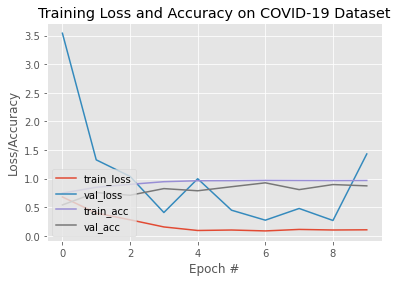

In [ ]:
### ResNet50
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=1)

#print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#testY = np.array([[0, 1.0], [0, 1.0], [1.0, 0]])

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['non covid', 'covid']))

# vp fp
# fn vn 

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
### MobileNetV2
model = model_mobilenetv2()
model.load_weights("./models/mobilenetv2/model_"+str(np.argmax(TEST_ACCURACY["mobilenetv2"])+1)+".h5")
results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test))
results_test = dict(zip(model.metrics_names,results_test))
print(results_test['accuracy'])

Number of layers in the base model:  156
48 layers were frozen
108 layers to fine-tune
497/497 [==============================] - 6s 10ms/step - loss: 0.1901 - accuracy: 0.9537
0.953722357749939


[INFO] evaluating network...
              precision    recall  f1-score   support

   non covid       0.96      0.89      0.93       238
       covid       0.91      0.97      0.94       259

    accuracy                           0.93       497
   macro avg       0.93      0.93      0.93       497
weighted avg       0.93      0.93      0.93       497

[[213  25]
 [  9 250]]
acc: 0.9316
sensitivity: 0.8950
specificity: 0.9653


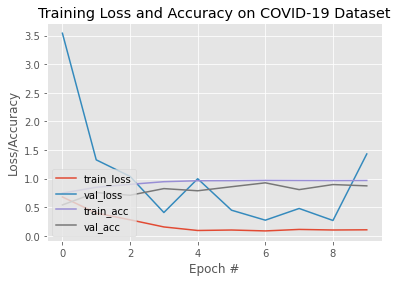

In [ ]:
### MobileNetV2
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=1)

#print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#testY = np.array([[0, 1.0], [0, 1.0], [1.0, 0]])

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['non covid', 'covid']))

# vp fp
# fn vn 

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
### VGG16
model = model_vgg16()
model.load_weights("./models/vgg16/model_"+str(np.argmax(TEST_ACCURACY["vgg16"])+1)+".h5")
results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test))
results_test = dict(zip(model.metrics_names,results_test))
print(results_test['accuracy'])

Number of layers in the base model:  21
20 layers were frozen
1 layers to fine-tune
497/497 [==============================] - 16s 31ms/step - loss: 0.0842 - accuracy: 0.9698
0.9698188900947571


[INFO] evaluating network...
              precision    recall  f1-score   support

   non covid       0.98      0.95      0.97       238
       covid       0.96      0.98      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497

[[226  12]
 [  4 255]]
acc: 0.9678
sensitivity: 0.9496
specificity: 0.9846


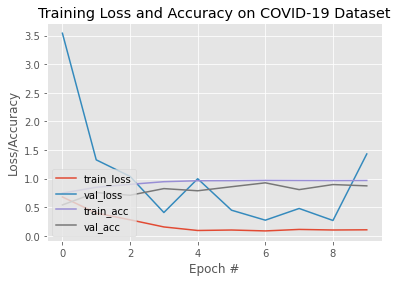

In [ ]:
### VGG16
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=1)

#print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#testY = np.array([[0, 1.0], [0, 1.0], [1.0, 0]])

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['non covid', 'covid']))

# vp fp
# fn vn 

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
### InceptionV3
model = model_inceptionv3()
model.load_weights("./models/inceptionv3/model_"+str(np.argmax(TEST_ACCURACY["inceptionv3"])+1)+".h5")
results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test))
results_test = dict(zip(model.metrics_names,results_test))
print(results_test['accuracy'])

Number of layers in the base model:  313
218 layers were frozen
95 layers to fine-tune
497/497 [==============================] - 12s 21ms/step - loss: 0.3420 - accuracy: 0.8672
0.8672032356262207


[INFO] evaluating network...
              precision    recall  f1-score   support

   non covid       0.88      0.84      0.86       238
       covid       0.86      0.89      0.87       259

    accuracy                           0.87       497
   macro avg       0.87      0.86      0.86       497
weighted avg       0.87      0.87      0.86       497

[[199  39]
 [ 28 231]]
acc: 0.8652
sensitivity: 0.8361
specificity: 0.8919


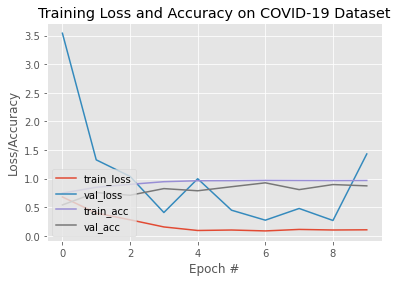

In [ ]:
### InceptionV3
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=1)

#print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#testY = np.array([[0, 1.0], [0, 1.0], [1.0, 0]])

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['non covid', 'covid']))

# vp fp
# fn vn 

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
### Xception
model = model_xception()
model.load_weights("./models/xception/model_"+str(np.argmax(TEST_ACCURACY["xception"])+1)+".h5")
results_test = model.evaluate(datasetGen_test, steps=len(imagePaths_test))
results_test = dict(zip(model.metrics_names,results_test))
print(results_test['accuracy'])

Number of layers in the base model:  134
93 layers were frozen
41 layers to fine-tune
497/497 [==============================] - 12s 22ms/step - loss: 0.2123 - accuracy: 0.9437
0.9436619877815247


[INFO] evaluating network...
              precision    recall  f1-score   support

   non covid       0.94      0.95      0.95       238
       covid       0.96      0.95      0.95       259

    accuracy                           0.95       497
   macro avg       0.95      0.95      0.95       497
weighted avg       0.95      0.95      0.95       497

[[227  11]
 [ 14 245]]
acc: 0.9497
sensitivity: 0.9538
specificity: 0.9459


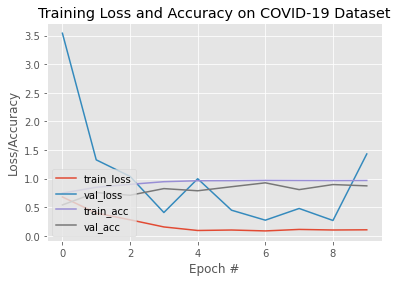

In [ ]:
### Xception
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=1)

#print(predIdxs)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

#testY = np.array([[0, 1.0], [0, 1.0], [1.0, 0]])

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=['non covid', 'covid']))

# vp fp
# fn vn 

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")